<a href="https://colab.research.google.com/github/ArunK-ML/Project---Brain-Tumor-MRI-Image-Classification/blob/main/Brain_Tumor_CNN_Best_Approch.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [107]:
# ========================================
# STEP 2: Mount Google Drive
# ========================================
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [108]:
!pip install tensorflow>=2.9.0 scikit-learn matplotlib pillow streamlit numpy

In [109]:
import keras
from keras.models import Sequential
from keras.layers import Conv2D,Flatten,Dense,MaxPooling2D,Dropout
from sklearn.metrics import accuracy_score
import ipywidgets as widgets
import io
from PIL import Image
import tqdm
from sklearn.model_selection import train_test_split
import cv2
from sklearn.utils import shuffle
import tensorflow as tf
import numpy as np
import os
import matplotlib.pyplot as plt

import random
from pathlib import Path
from collections import Counter, defaultdict
import pandas as pd
from tqdm import tqdm

In [120]:

# Paths
TRAIN_DIR = "/content/drive/MyDrive/Project_DataSets_GUVI/Tumour-20250909T193851Z-1-001/Tumour/train"
TEST_DIR  = "/content/drive/MyDrive/Project_DataSets_GUVI/Tumour-20250909T193851Z-1-001/Tumour/test"
VALID_DIR = "/content/drive/MyDrive/Project_DataSets_GUVI/Tumour-20250909T193851Z-1-001/Tumour/valid"

# Params
image_size = 150
labels = ['glioma','meningioma','no_tumor','pituitary']

# Lists
X_train, Y_train = [], []
X_test,  Y_test  = [], []
X_val,   Y_val   = [], []

# Training Data
for i in labels:
    folderPath = os.path.join(TRAIN_DIR, i)
    for j in os.listdir(folderPath):
        img = cv2.imread(os.path.join(folderPath,j))
        if img is not None:
            img = cv2.resize(img, (image_size,image_size))
            X_train.append(img)
            Y_train.append(i)

# Testing Data
for i in labels:
    folderPath = os.path.join(TEST_DIR, i)
    for j in os.listdir(folderPath):
        img = cv2.imread(os.path.join(folderPath,j))
        if img is not None:
            img = cv2.resize(img, (image_size,image_size))
            X_test.append(img)
            Y_test.append(i)

# Validation Data
for i in labels:
    folderPath = os.path.join(VALID_DIR, i)
    for j in os.listdir(folderPath):
        img = cv2.imread(os.path.join(folderPath,j))
        if img is not None:
            img = cv2.resize(img, (image_size,image_size))
            X_val.append(img)
            Y_val.append(i)

# Convert to numpy arrays
X_train = np.array(X_train)
X_test  = np.array(X_test)
X_val   = np.array(X_val)

# Label encoding
y_train = [labels.index(i) for i in Y_train]
y_test  = [labels.index(i) for i in Y_test]
y_val   = [labels.index(i) for i in Y_val]

# One-hot encoding
y_train = tf.keras.utils.to_categorical(y_train, num_classes=len(labels))
y_test  = tf.keras.utils.to_categorical(y_test, num_classes=len(labels))
y_val   = tf.keras.utils.to_categorical(y_val, num_classes=len(labels))

print("Train:", X_train.shape, y_train.shape)
print("Test:", X_test.shape, y_test.shape)
print("Valid:", X_val.shape, y_val.shape)


Train: (1695, 150, 150, 3) (1695, 4)
Test: (246, 150, 150, 3) (246, 4)
Valid: (502, 150, 150, 3) (502, 4)


# **Understand the Dataset**

/tmp/ipython-input-3632425642.py:17: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x=y_data, order=labels, palette="Set2")


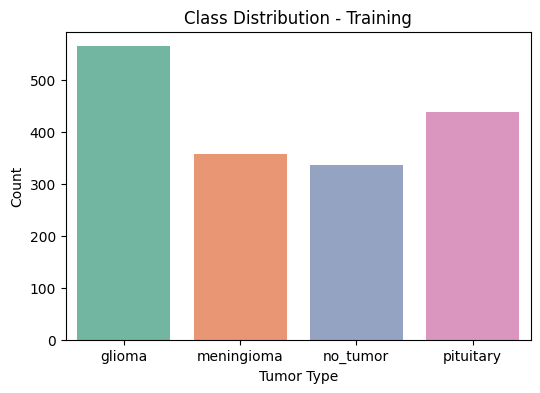

/tmp/ipython-input-3632425642.py:17: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x=y_data, order=labels, palette="Set2")


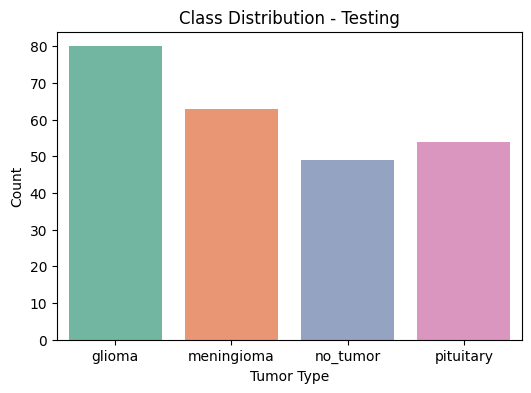

/tmp/ipython-input-3632425642.py:17: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x=y_data, order=labels, palette="Set2")


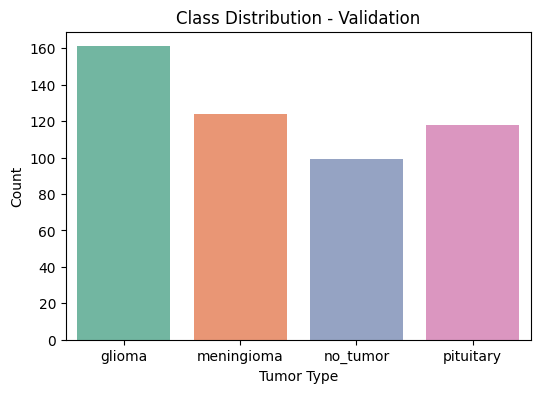

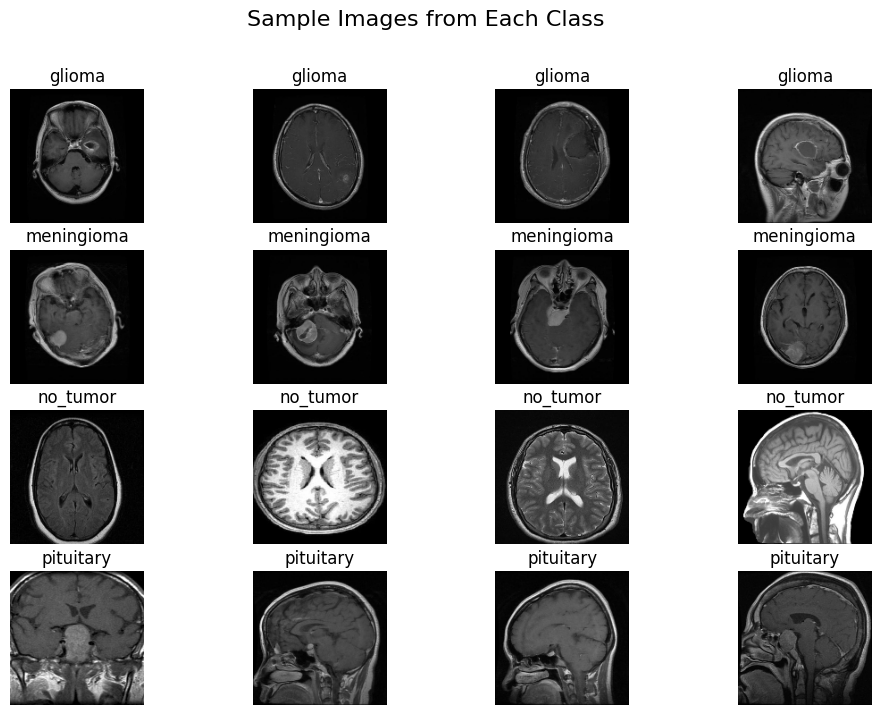

Image shape: (150, 150, 3)

Pixel intensity stats (0–1 scale):
Train - min: 0 max: 255 mean: 43.724265093411994
Test  - min: 0 max: 255 mean: 44.73530972598615
Valid - min: 0 max: 255 mean: 43.1103348089125


In [121]:
import matplotlib.pyplot as plt
import seaborn as sns

# Decode one-hot labels back to class names
def decode_labels(y_encoded, label_names):
    return [label_names[np.argmax(vec)] for vec in y_encoded]

y_train_decoded = decode_labels(y_train, labels)
y_test_decoded  = decode_labels(y_test, labels)
y_val_decoded   = decode_labels(y_val, labels)

# ================================
# 1. Class Distribution (Counts)
# ================================
def plot_class_distribution(y_data, dataset_name="Dataset"):
    plt.figure(figsize=(6,4))
    sns.countplot(x=y_data, order=labels, palette="Set2")
    plt.title(f"Class Distribution - {dataset_name}")
    plt.xlabel("Tumor Type")
    plt.ylabel("Count")
    plt.show()

plot_class_distribution(y_train_decoded, "Training")
plot_class_distribution(y_test_decoded, "Testing")
plot_class_distribution(y_val_decoded, "Validation")

# ================================
# 2. Show Sample Images
# ================================
def show_sample_images(X, y_decoded, n_samples=4):
    plt.figure(figsize=(12, 8))
    for i, label in enumerate(labels):
        # Pick indices of this class
        idxs = [j for j, val in enumerate(y_decoded) if val == label]
        for k in range(n_samples):
            if k < len(idxs):
                plt.subplot(len(labels), n_samples, i*n_samples + k + 1)
                plt.imshow(X[idxs[k]])
                plt.title(label)
                plt.axis("off")
    plt.suptitle("Sample Images from Each Class", fontsize=16)
    plt.show()

show_sample_images(X_train, y_train_decoded, n_samples=4)

# ================================
# 3. Image Shape & Pixel Stats
# ================================
print("Image shape:", X_train.shape[1:])  # should be (150,150,3)

print("\nPixel intensity stats (0–1 scale):")
print("Train - min:", np.min(X_train), "max:", np.max(X_train), "mean:", np.mean(X_train))
print("Test  - min:", np.min(X_test),  "max:", np.max(X_test),  "mean:", np.mean(X_test))
print("Valid - min:", np.min(X_val),   "max:", np.max(X_val),   "mean:", np.mean(X_val))


# **Data Preprocessing**

**Normalize pixel values to a 0–1 range.**

**Resize images to a consistent shape suitable for model input (e.g. 224x224 pixels).**

In [122]:
import cv2

# New target size for deep CNN models
target_size = 224

def preprocess_images(X, new_size=224):
    X_resized = []
    for img in X:
        # Resize each image
        resized = cv2.resize(img, (new_size, new_size))
        X_resized.append(resized)
    X_resized = np.array(X_resized, dtype="float32")
    # Normalize pixel values (0–255 → 0–1)
    X_resized = X_resized / 255.0
    return X_resized

# Apply preprocessing
X_train = preprocess_images(X_train, target_size)
X_test  = preprocess_images(X_test,  target_size)
X_val   = preprocess_images(X_val,   target_size)

print("✅ After preprocessing:")
print("Train:", X_train.shape, y_train.shape)
print("Test :", X_test.shape, y_test.shape)
print("Valid:", X_val.shape, y_val.shape)
print("Pixel range:", X_train.min(), "to", X_train.max())

✅ After preprocessing:
Train: (1695, 224, 224, 3) (1695, 4)
Test : (246, 224, 224, 3) (246, 4)
Valid: (502, 224, 224, 3) (502, 4)
Pixel range: 0.0 to 1.0


# **Model Building**

# **CNN Arch.**

In [139]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Dropout, Flatten, Dense, BatchNormalization, GlobalAveragePooling2D

model = Sequential()

# Block 1
model.add(Conv2D(32,(3,3),activation = 'relu',input_shape=(224,224,3)))
model.add(Conv2D(64,(3,3),activation='relu'))
model.add(MaxPooling2D(2,2))
model.add(Dropout(0.3))

model.add(Conv2D(64,(3,3),activation='relu'))
model.add(Conv2D(64,(3,3),activation='relu'))
model.add(Dropout(0.3))
model.add(MaxPooling2D(2,2))
model.add(Dropout(0.3))

model.add(Conv2D(128,(3,3),activation='relu'))
model.add(Conv2D(128,(3,3),activation='relu'))
model.add(Conv2D(128,(3,3),activation='relu'))
model.add(MaxPooling2D(2,2))
model.add(Dropout(0.3))
model.add(Conv2D(128,(3,3),activation='relu'))

model.add(Conv2D(256,(3,3),activation='relu'))
model.add(MaxPooling2D(2,2))
model.add(Dropout(0.3))
model.add(Flatten())

model.add(Dense(512,activation = 'relu'))
model.add(Dense(512,activation = 'relu'))
model.add(Dropout(0.3))
model.add(Dense(4,activation='softmax'))


/usr/local/lib/python3.12/dist-packages/keras/src/layers/convolutional/base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [140]:
model.summary()

Model: "sequential_11"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_165 (Conv2D)             │ (None, 222, 222, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_166 (Conv2D)             │ (None, 220, 220, 64)   │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_36 (MaxPooling2D) │ (None, 110, 110, 64)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_57 (Dropout)            │ (None, 110, 110, 64)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_167 (Conv2D)             │ (None, 108, 108, 64)   │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_168 (Conv2D)             │ (None, 106, 106, 64)   │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_58 (Dropout)            │ (None, 106, 106, 64)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_37 (MaxPooling2D) │ (None, 53, 53, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_59 (Dropout)            │ (None, 53, 53, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_169 (Conv2D)             │ (None, 51, 51, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_170 (Conv2D)             │ (None, 49, 49, 128)    │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_171 (Conv2D)             │ (None, 47, 47, 128)    │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_38 (MaxPooling2D) │ (None, 23, 23, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_60 (Dropout)            │ (None, 23, 23, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_172 (Conv2D)             │ (None, 21, 21, 128)    │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_173 (Conv2D)             │ (None, 19, 19, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_39 (MaxPooling2D) │ (None, 9, 9, 256)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_61 (Dropout)            │ (None, 9, 9, 256)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_7 (Flatten)             │ (None, 20736)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_29 (Dense)                │ (None, 512)            │    10,617,344 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_30 (Dense)                │ (None, 512)            │       262,656 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_62 (Dropout)            │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_31 (Dense)                │ (None, 4)              │         2,052 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 11,787,076 (44.96 MB)

 Trainable params: 11,787,076 (44.96 MB)

 Non-trainable params: 0 (0.00 B)

In [141]:
model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

In [142]:
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint

# Callbacks
early_stop = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
reduce_lr  = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=3, verbose=1)  # <-- fixed
checkpoint = ModelCheckpoint('best_model.keras', monitor='val_loss', save_best_only=True)  # use .keras format

# Training
history = model.fit(
    X_train, y_train,
    epochs=20,
    batch_size=32,
    validation_data=(X_val, y_val),
    callbacks=[early_stop, reduce_lr, checkpoint],
    verbose=1
)


Epoch 1/20
53/53 ━━━━━━━━━━━━━━━━━━━━ 38s 483ms/step - accuracy: 0.3319 - loss: 1.4425 - val_accuracy: 0.5259 - val_loss: 1.1419 - learning_rate: 0.0010
Epoch 2/20
53/53 ━━━━━━━━━━━━━━━━━━━━ 36s 560ms/step - accuracy: 0.6171 - loss: 0.9928 - val_accuracy: 0.6195 - val_loss: 0.8821 - learning_rate: 0.0010
Epoch 3/20
53/53 ━━━━━━━━━━━━━━━━━━━━ 40s 541ms/step - accuracy: 0.7182 - loss: 0.7944 - val_accuracy: 0.6992 - val_loss: 0.7137 - learning_rate: 0.0010
Epoch 4/20
53/53 ━━━━━━━━━━━━━━━━━━━━ 22s 186ms/step - accuracy: 0.7739 - loss: 0.6281 - val_accuracy: 0.6036 - val_loss: 1.0216 - learning_rate: 0.0010
Epoch 5/20
53/53 ━━━━━━━━━━━━━━━━━━━━ 34s 653ms/step - accuracy: 0.7816 - loss: 0.5558 - val_accuracy: 0.7629 - val_loss: 0.5831 - learning_rate: 0.0010
Epoch 6/20
53/53 ━━━━━━━━━━━━━━━━━━━━ 17s 187ms/step - accuracy: 0.8174 - loss: 0.4886 - val_accuracy: 0.7410 - val_loss: 0.7399 - learning_rate: 0.0010
Epoch 7/20
53/53 ━━━━━━━━━━━━━━━━━━━━ 10s 188ms/step - accuracy: 0.8657 - loss: 0.

# **Save Model**

In [132]:
model.save("braintumor_Final.h5")
print("Model saved successfully 🚀")

Model saved successfully 🚀


# **Plot**

In [143]:
import matplotlib.pyplot as plt
import seaborn as sns

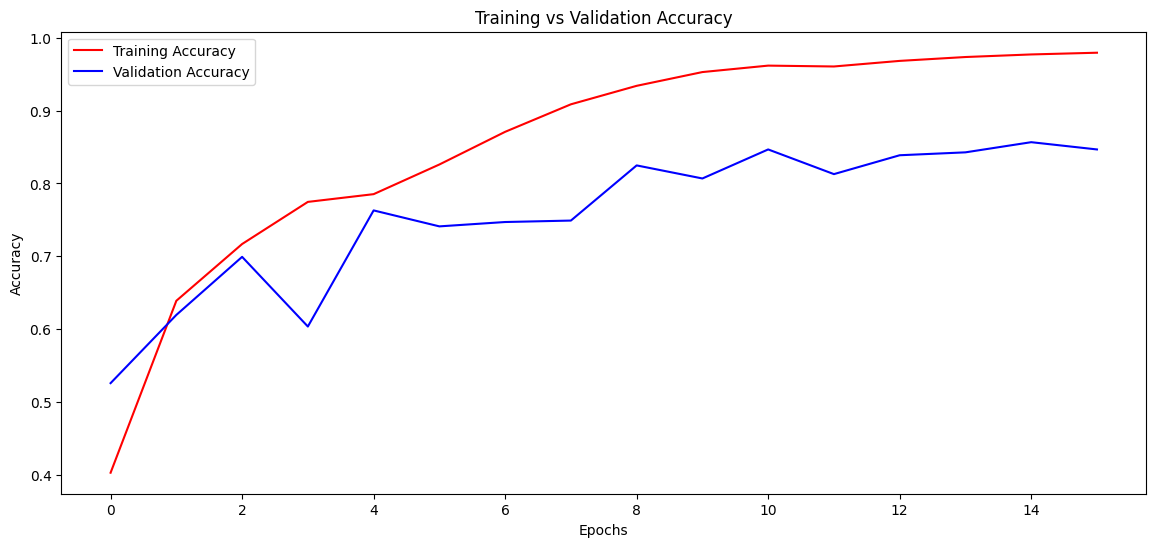

In [144]:
#model.save('braintumor.h5')
# Training history
acc     = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss    = history.history['loss']
val_loss= history.history['val_loss']
epochs  = range(len(acc))

# Plot Accuracy
plt.figure(figsize=(14,6))
plt.plot(epochs, acc, 'r', label="Training Accuracy")
plt.plot(epochs, val_acc, 'b', label="Validation Accuracy")
plt.title("Training vs Validation Accuracy")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend()
plt.show()

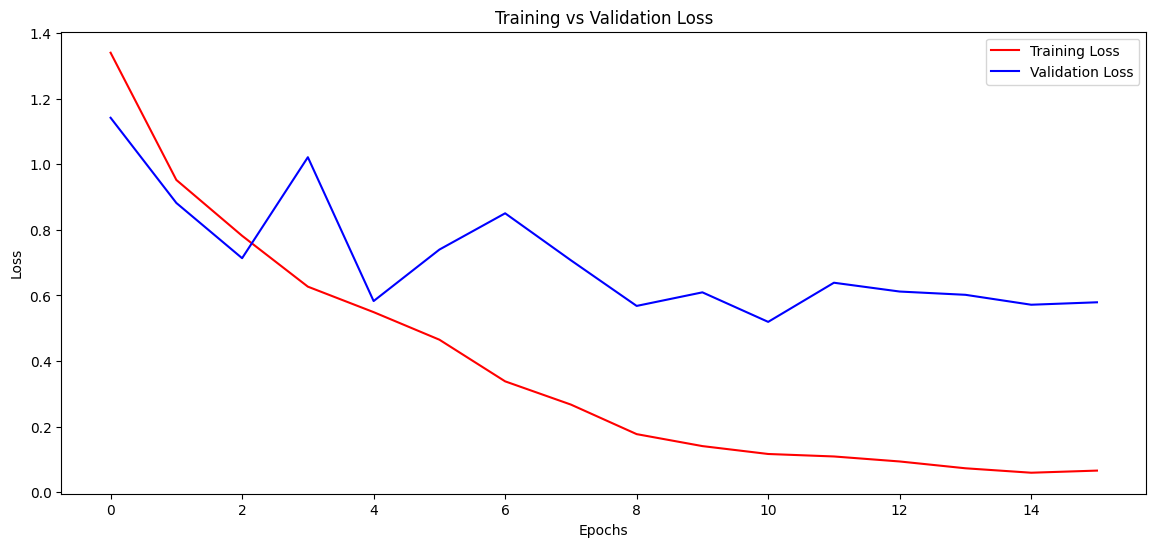

In [145]:
# Plot Loss
plt.figure(figsize=(14,6))
plt.plot(epochs, loss, 'r', label="Training Loss")
plt.plot(epochs, val_loss, 'b', label="Validation Loss")
plt.title("Training vs Validation Loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()
plt.show()

# **Test the Model**

check 1 - meningioma

In [146]:
img = cv2.imread('/content/drive/MyDrive/Project_DataSets_GUVI/Tumour-20250909T193851Z-1-001/Tumour/train/meningioma/Tr-me_0551_jpg.rf.58c4d99195ebc75bb6af47123a856a97.jpg')
img = cv2.resize(img,(150,150))
img_array = np.array(img)
img_array.shape

(150, 150, 3)

In [148]:
# Resize the image to the target size (224x224)
img_resized = cv2.resize(img_array, (target_size, target_size))

# Reshape the resized image array for prediction
img_array = img_resized.reshape(1, target_size, target_size, 3)
print(img_array.shape)

(1, 224, 224, 3)


In [149]:
a=model.predict(img_array)
indices = a.argmax()
indices

1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step


np.int64(1)

check2 - glioma

In [150]:
img = cv2.imread('/content/drive/MyDrive/Project_DataSets_GUVI/Tumour-20250909T193851Z-1-001/Tumour/train/glioma/Tr-gl_0019_jpg.rf.6402e96f1a18221808a378aece0b4a5d.jpg')
img = cv2.resize(img,(150,150))
img_array = np.array(img)
img_array.shape

(150, 150, 3)

In [151]:
a = model.predict(img_array)
indices = a.argmax()
predicted_label = labels[indices]

print(f"Predicted class index: {indices}")
print(f"Predicted tumor type: {predicted_label}")

ValueError: Exception encountered when calling Sequential.call().

[1mCannot take the length of shape with unknown rank.[0m

Arguments received by Sequential.call():
  • inputs=tf.Tensor(shape=<unknown>, dtype=uint8)
  • training=False
  • mask=None
  • kwargs=<class 'inspect._empty'>

In [152]:
img_array = img_array.reshape(1,224,224,3)
img_array.shape

ValueError: cannot reshape array of size 67500 into shape (1,224,224,3)

In [ ]:
a=model.predict(img_array)
indices = a.argmax()
indices

check3- no tumor

In [ ]:
img = cv2.imread('/content/drive/MyDrive/Project_DataSets_GUVI/Tumour-20250909T193851Z-1-001/Tumour/train/no_tumor/Tr-no_0021_jpg.rf.660b878cd731bac20110b5135365001d.jpg')
img = cv2.resize(img,(150,150))
img_array = np.array(img)
img_array.shape

In [ ]:
img_array = img_array.reshape(1,224,224,3)
img_array.shape

In [ ]:
a=model.predict(img_array)
indices = a.argmax()
indices

check 4 - pituitary

In [ ]:
img = cv2.imread("/content/drive/MyDrive/Project_DataSets_GUVI/Tumour-20250909T193851Z-1-001/Tumour/train/pituitary/Tr-pi_0029_jpg.rf.2750d010652f4fd08d1c7049890817b7.jpg")
img = cv2.resize(img,(150,150))
img_array = np.array(img)
img_array.shape

In [ ]:
img_array = img_array.reshape(1,224,224,3)
img_array.shape

In [ ]:
a=model.predict(img_array)
indices = a.argmax()
indices